# Ячейка с импортом библиотек

In [2]:
import numpy as np
import math
from iotoolbox import *
from mathtoolbox import *

# Если есть желание сделать графики интерактивными (чтобы был зум и перемещение), 
# снимите комментарий с одной из следующих строчек:
%matplotlib widget  
# %matplotlib qtagg

#### Параметры моделирования и распределения:
$ \text{Частота дискретизации, } f_{discretization} - \text{f\_d  [Гц]} ; \\$
$ \text{Интервал дискретизации, } t_{discretization}=1/f_{discretization} - \text{t\_d  [с]}; \\$
$ \text{Интервал наблюдения, } t_{window} - \text{t\_win  [с]}; \\ $
$ \text{Длительность импульса, } t_{chirp} - \text{t\_ch  [с]}; \\ $
$ \text{Частота несущей, } f_{carrier} - \text{t\_ch  [Гц]}; \\ $
$ \text{Частота модулирующей гармоники, } f_{modulation} - \text{f\_mod  [Гц]}; \\ $ 
$ \text{Индекс модуляции, } i_{modulation} - \text{i\_mod  }. \\ $

In [3]:
f_d = 1e9              # частота дискретизации, Гц
t_d = 1/f_d            # период дискретизации
t_win = 2e-7           # длительность рассматриваемого интервала
t_ch = 8e-9            # длительность импульса (t chirp)
f_car = 140e6          # частота несущей, Гц

f_mod = 5e6 # частота модулирующей синусоиды
i_mod = 0.5 # индекс модуляции (глубина)

# Формирование рассматриваемых сигналов

In [4]:
s_v = generate_single_chip('video', t_d, t_win, t_ch)   # в/импульс
s_r = generate_single_chip('radio', t_d, t_win, t_ch, f_car)    # р/импульс
s_am = generate_single_chip('AM', t_d, t_win, f_car, f_mod, i_mod)  # АМ сигнал

# Выбираем сигнал, с которым далее будем работать, в соответствии с вариантом
# Также циклически "сдвигаем" отсчеты сигнала, чтобы, например, видеоимпульс
# начинался не с первого же отсчета
signal = np.roll(s_v, 
                math.floor(len(s_r)/2)) # выбрать сигнал для отображения


# Графики

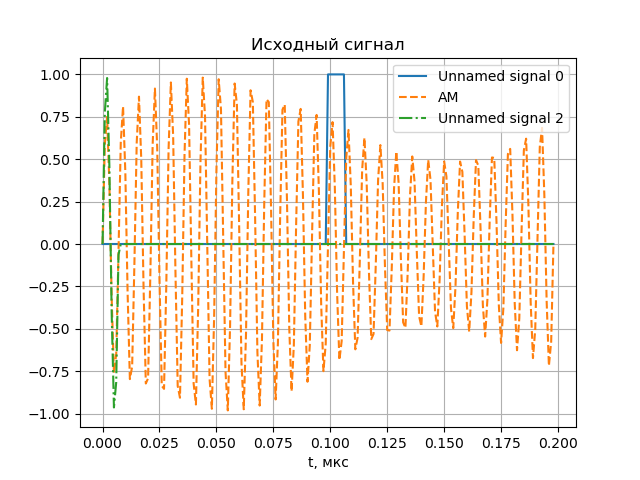

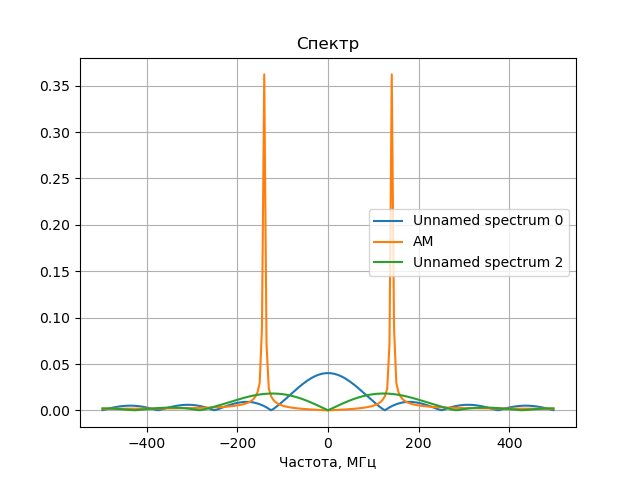

In [5]:
# "Упаковка" сигналов, на которые хотим посмотреть, в вид, распознаваемый
# функциями отрисовки. Подробности см. в описаниях функций plot_signal()
# и plot_spectrum()
signal_out = [[t_d, signal], 
              [t_d, s_am, 'AM'],
              [t_d, s_r]]

plot_signal(signal_out) # отобразить сигнал
plot_spectum(signal_out)    # отобразить спектр сигнала

# Сравнение фильтров

In [6]:
signal_in = signal  # выбрать сигнал, который будет отфильтрован
                    # Переменная нужна, чтобы во все фильтры гарантированно
                    # попал один и тот же сигнал, иначе можно сравнивать
                    # разные сигналы и удивлять, что они разные
f_type = 'LP'   # тип фильтра (LP/HP/BP/S)
f_cut_hz = 1/t_ch   # частота среза, Гц
but_order = 3   # порядок фильтра Баттерворта
cheb_order = 5  # порядок фильтра Чебышева
s_band_attenuation_db = 20  # внеполосное ослабление лепестков для фильтра Чебышева

# Применить к сигналу фильтры. Подробности в описании функций
signal_out_idl = apply_ideal_filter(t_d, f_type, f_cut_hz, signal_in)   # применить к сигналу идеальный фильтр
signal_out_btr = apply_butt_filter(t_d, f_type, f_cut_hz, but_order, signal_in) # применить к сигналу ф. Баттерворта
signal_out_chb = apply_cheb2_filter(t_d, f_type, f_cut_hz, cheb_order, s_band_attenuation_db, signal_in)    # применить к сигналу ф. Чебышева

# Графики 
#### Сигнал во временной области и его АЧХ

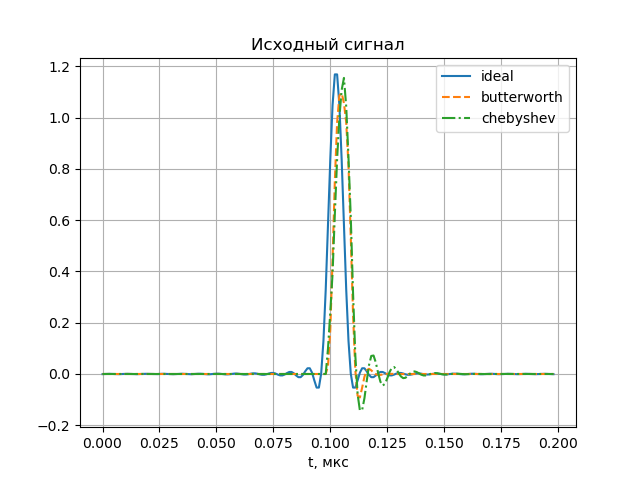

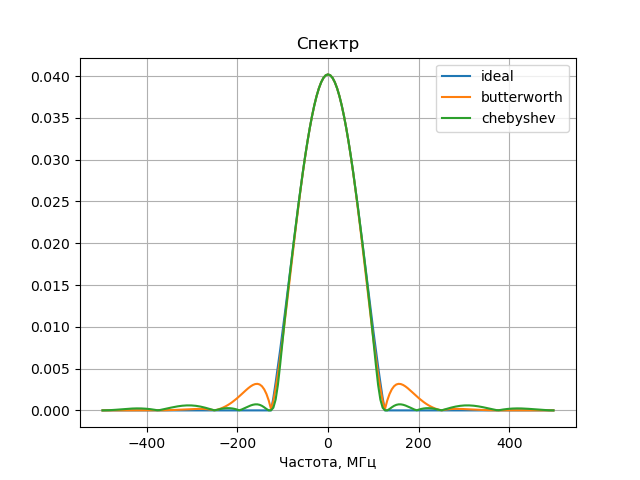

In [7]:
# Отображение данных
signal_out = [[t_d, signal_out_idl, 'ideal'],
              [t_d, signal_out_btr, 'butterworth'], 
              [t_d, signal_out_chb, 'chebyshev']] # конкатенация рез-татов фильтрации
plot_signal(signal_out) # отобразить фильтрованные сигналы
plot_spectum(signal_out) # отобразить спектр 

# Построение импульсной характеристики фильтров 

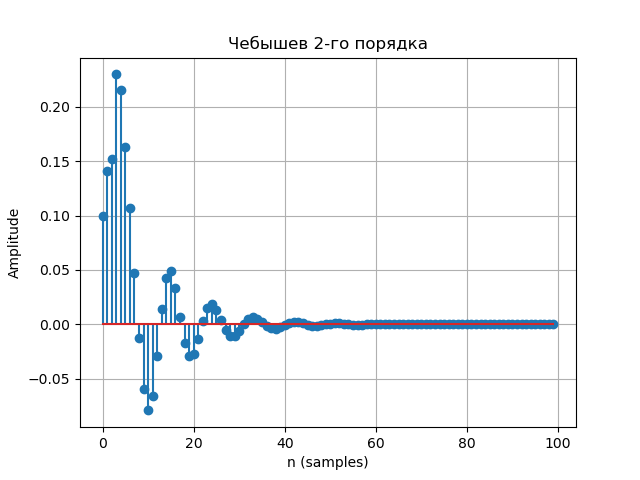

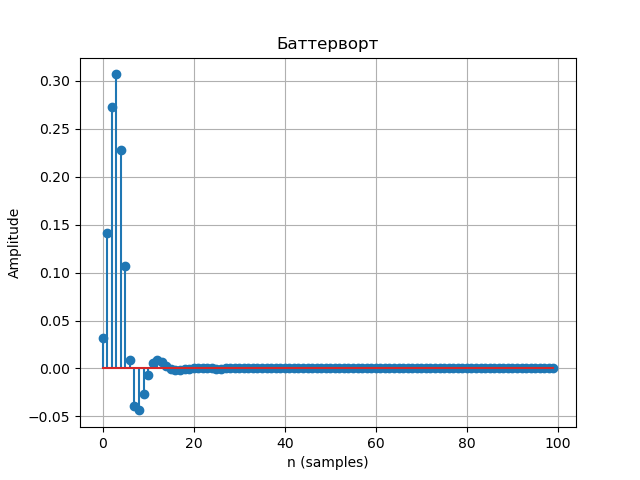

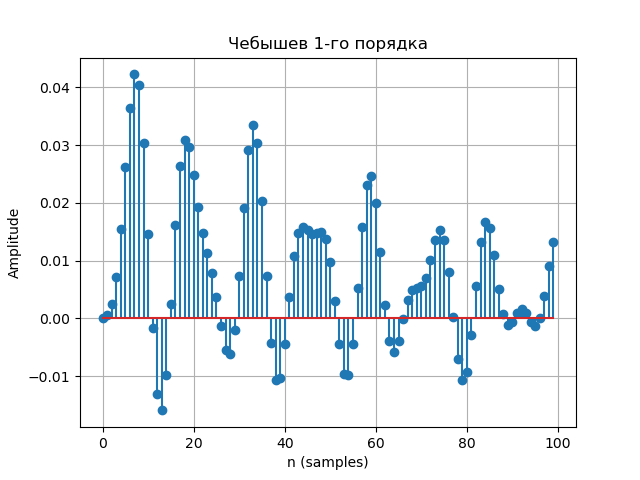

In [ ]:
# Получение коэффициентов передаточной функции фильтров для построения импульсной характеристики
b_cheb2, a_cheb2 = create_cheb2_filter(t_d, f_type, f_cut_hz, cheb_order, s_band_attenuation_db)    # формирование фильтра Чебышего 2-го порядка
b_butt, a_butt = create_butt_filter(t_d, f_type, f_cut_hz, but_order)   # формирование фильтра Баттерворта
b_cheb1, a_cheb1 = create_cheb1_filter(t_d, f_type, f_cut_hz, cheb_order, s_band_attenuation_db)    # формирование фильтра Чебышего 1-го порядка
n_imp_resp = 2^7   # длительность интервала (в отсчетах) для которого строится имп. характеристика
n_freq_resp = 2^10  # число отсчетов АЧХ и ФЧХ

b = [b_cheb2, b_butt, b_cheb1]
a = [a_cheb2, a_butt, a_cheb1]
legend_filters = ['Чеб 2-го пор', 'Батт', 'Чеб1-го пор']
   
impz(b_cheb2,a_cheb2, 'Чебышев 2-го порядка')
impz(b_butt,a_butt, 'Баттерворт')
impz(b_cheb1,a_cheb1, 'Чебышев 1-го порядка')



# Построение импульсной характеристики фильтров 

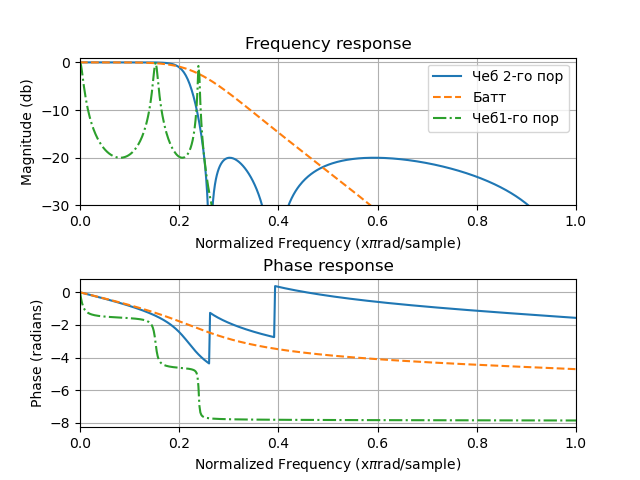

In [10]:
mfreqz3(b, a, legend_filters)